# Network effects on peak and epidemic size

_Corey Chivers <corey.chivers@pennmedicine.upenn.edu>_

## Summary
- CHIME uses the standard SIR model to project hospital demand
- The standard model assumes homogeneous mixing of individuals (so called 'mass action')
- In reality, people interact with others over networks of indiviudals they are more likely to come in contact with
- Early phase exponential growth curves are compatible with **both** mass action and networked models yet:
    - Incorporating this fact leads to substantially different projections
    - Networked models result in smaller, earlier peak demand and smaller overall epidemic size (number infected)

Extensions based on the work of:

- Bansal, Shweta, Bryan T. Grenfell, and Lauren Ancel Meyers. ["When individual behaviour matters: homogeneous and network models in epidemiology."](https://royalsocietypublishing.org/doi/pdf/10.1098/rsif.2007.1100) Journal of the Royal Society Interface 4.16 (2007): 879-891. 

This notebook implements two [extentions](https://royalsocietypublishing.org/action/downloadSupplement?doi=10.1098%2Frsif.2007.1100&file=rsif20071100supp1.pdf) of the standard SIR which approximate networked contact structures, demonstrating that incorporating contact structure can result in substantially smaller epidemic sizes while demonstrating exponential early-stage growth.



In [1]:
%pylab inline
import pandas as pd
from typing import Dict, Generator, Tuple

Populating the interactive namespace from numpy and matplotlib


In [2]:
def sir(
    s: float, i: float, r: float,
    beta: float, gamma: float, n: float,
) -> Tuple[float, float, float]:
    """The SIR model, one time step."""
    s_n = (-beta * s * i) + s
    i_n = (beta * s * i - gamma * i) + i
    r_n = gamma * i + r
    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale

def gen_sir(
    s: float, i: float, r: float,
    beta: float, gamma: float, n_days: int,
) -> Generator[Tuple[int, float, float, float], None, None]:
    """Simulate SIR model forward in time yielding tuples."""
    s, i, r = (float(v) for v in (s, i, r))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r
        s, i, r = sir(s, i, r, beta, gamma, n)

# Standard SIR - Mass Action, random mixing

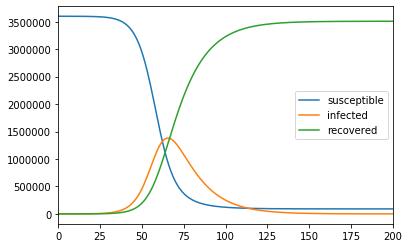

In [3]:
i_0 = 100
s, i, r = 3600000, i_0, 0
doubling_time = 4.0
recovery_days = 14.0
intrinsic_growth_rate = 2**(1.0 / doubling_time) - 1
gamma = 1.0 / recovery_days
beta = (intrinsic_growth_rate + gamma) / s
n_days = 200

sim_df = pd.DataFrame(data=gen_sir(s, i, r, beta, gamma, n_days),
            columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot()

- Recovered -> ~ population size at end of epidemic (eg. almost everyone gets infected eventually)

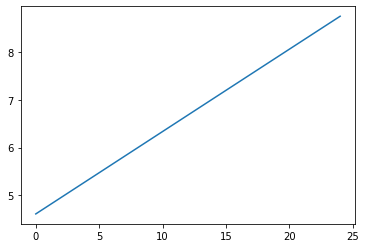

In [4]:
# Fits exponential growth early on
fig, ax = plt.subplots(1,1)
ax.plot(np.log(sim_df['infected'].head(25)))

# SIR extension 1 - Pair-approximation
>Pair approximation methods (Keeling 1999) are based on a differential
equation model of counting the number of pairs of
individuals in each disease class. These methods are
particularly useful for networks with clustering or
spatial networks. 

![image.png](https://user-images.githubusercontent.com/1396669/78389710-352ca180-75b1-11ea-9f05-bf7066ff4dc9.png)

In [5]:
def sir_keeling(
    s: float, i: float, r: float, si: float, ss: float,
    alpha: float, beta: float, gamma: float, n: float,
) -> Tuple[float, float, float]:
    """The SIR keeling model, one time step."""
    s_n = (-beta * si) + s
    i_n = (beta * si - gamma * i) + i
    si_n = (((beta * si) / (s)) * ( ((alpha-1) * ss) - ((alpha-1) * si) - alpha*s ) - gamma * si) + si
    ss_n = (-2 * ((beta * si) / (s)) * (alpha - 1) * ss) + ss
    r_n = gamma * i + r
    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale, si_n, ss_n

def gen_sir_keeling(
    s: float, i: float, r: float, si: float, ss: float,
    alpha: float, beta: float, gamma: float, n_days: int,
) -> Generator[Tuple[int, float, float, float, float, float], None, None]:
    """Simulate SIR keeling model forward in time yielding tuples."""
    s, i, r, si, ss = (float(v) for v in (s, i, r, si, ss))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r, si, ss
        s, i, r, si, ss = sir_keeling(s, i, r, si, ss, alpha, beta, gamma, n)

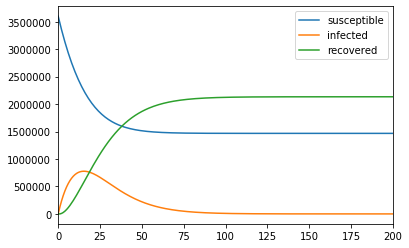

In [6]:
i_0 = 100
s, i, r, si, ss = 3600000, i_0, 0, i_0*1000, 10
alpha = 0.01
doubling_time = 4.0
recovery_days = 14.0
intrinsic_growth_rate = 2**(1.0 / doubling_time) - 1
gamma = 1.0 / recovery_days
beta = 1 + (intrinsic_growth_rate + gamma)
n_days = 200

sim_df = pd.DataFrame(data=gen_sir_keeling(s, i, r, si, ss, alpha, beta, gamma, n_days),
            columns = ("day", "susceptible", "infected", "recovered", "si", "ss"))
sim_df[["susceptible","infected", "recovered"]].plot()

- Recovered << population size at end of epidemic
- Earlier, smaller peak and shorter exponential phase

# SIR extension 2 - Power-law modification

> Stroud et al. (2006) modify the term representing the proportion of susceptibles in the homogeneous mixing model with an empirical exponent $S/N^\nu$, where $\nu$ is estimated from simulation data.

![image.png](https://user-images.githubusercontent.com/1396669/78389751-4bd2f880-75b1-11ea-8283-fc5bc9461eac.png)

In [7]:
def sir_stroud(
    s: float, i: float, r: float,
    beta: float, nu: float, gamma: float, n: float,
) -> Tuple[float, float, float]:
    """The SIR stroud model, one time step."""
    s_n = (-beta) * (s/n)**nu * i + s
    i_n = (beta * (s/n)**nu * i  - gamma * i) + i
    r_n = gamma * i + r
    scale = n / (s_n + i_n + r_n)
    return s_n * scale, i_n * scale, r_n * scale


def gen_sir_stroud(
    s: float, i: float, r: float,
    beta: float, nu: float, gamma: float, n_days: int,
) -> Generator[Tuple[int, float, float, float], None, None]:
    """Simulate SIR stroud model forward in time yielding tuples."""
    s, i, r = (float(v) for v in (s, i, r))
    n = s + i + r
    for d in range(n_days + 1):
        yield d, s, i, r
        s, i, r = sir_stroud(s, i, r, beta, nu, gamma, n)

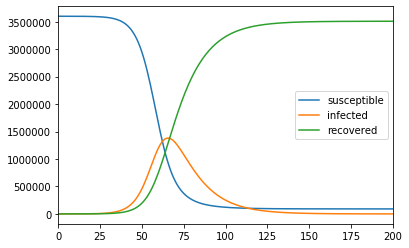

In [8]:
i_0 = 100
s, i, r = 3600000, i_0, 0
doubling_time = 4.0
recovery_days = 14.0
intrinsic_growth_rate = 2**(1.0 / doubling_time) - 1
gamma = 1.0 / recovery_days
beta = (intrinsic_growth_rate + gamma)
nu = 1.0
n_days = 200

sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
            columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot()

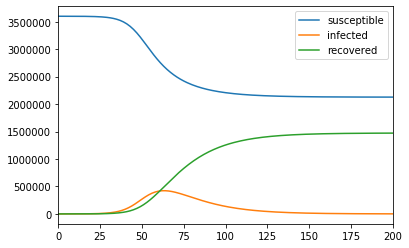

In [9]:
nu = 4.5
n_days = 200

sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
            columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot()

Text(0, 0.5, 'Epidemic Size (total number infected)')

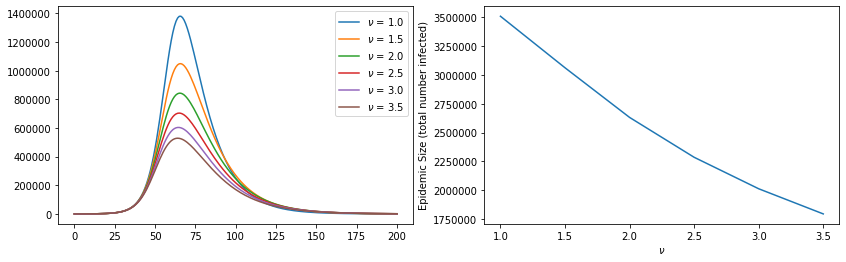

In [10]:
fig, axx = plt.subplots(1,2, figsize=(14,4))
ax = axx[0]
nus = np.linspace(1.0,3.5,6)
epi_size = []
for nu in nus:
    sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
                columns = ("day", "susceptible", "infected", "recovered"))
    ax.plot(sim_df["infected"], label=r"$\nu$ = {}".format(nu))
    epi_size.append(sim_df["recovered"].values[-1])
ax.legend(loc=0)

ax = axx[1]
ax.plot(nus, epi_size)
ax.set_xlabel(r'$\nu$')
ax.set_ylabel('Epidemic Size (total number infected)')

In [11]:
epi_size

[3508747.133474542,
 3061889.0336811836,
 2631527.593961688,
 2285775.2444195254,
 2012725.438553607,
 1794687.4427280636]

## Fitting

- Given the first $n$ days of progression, how different are the case counts under difference $\nu$?

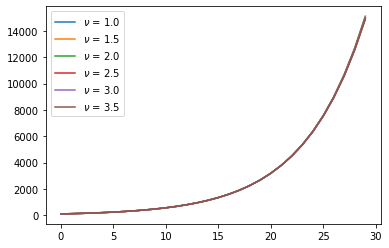

In [12]:
fig, ax = plt.subplots(1,1)
for nu in nus:
    sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
                columns = ("day", "susceptible", "infected", "recovered"))
    ax.plot(sim_df["infected"].head(30), label=r"$\nu$ = {}".format(nu))
ax.legend(loc=0)

- Even over large a range of $\nu$ that covers a 2x range of epidemic size, the curves are indistinguishable during the first 30 days.

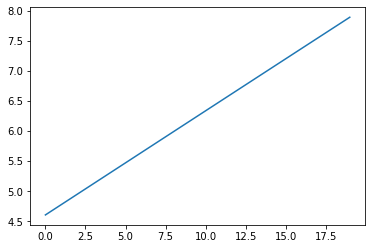

In [13]:
# Fits exponential growth early on
fig, ax = plt.subplots(1,1)
ax.plot(np.log(sim_df['infected'].head(20)))

# Individual Based Model (IBM) of Networked Contacts
- Build a stochastic IBM to analyse network effects explicitly
- Use simulations from the IBM to find reasonable exponents for the Stroud approximation

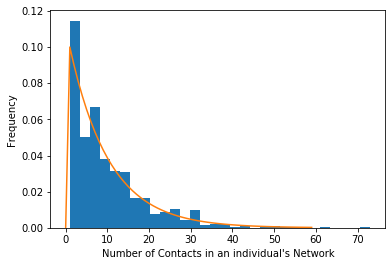

Text(0, 0.5, 'Frequency')

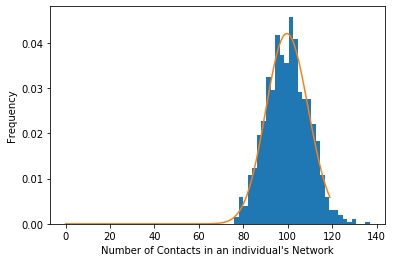

In [118]:
from random import shuffle
from scipy.stats import geom, binom

def gen_network(n=1000, distribution='exp', p=0.1):
    """Generate a random graph using the Configuration model."""
    stubs = []
    for i in range(0, n):
        if distribution == 'exp':
            degree = geom.rvs(p)
        elif distribution == 'uniform':
            degree = int(n*p)
        elif distribution == 'random':
            degree = binom.rvs(n, p)
        stubs += [i] * degree

    shuffle(stubs)

    G = {}
    for i in range(0, n):
        G[i] = []

    for i in range(1, len(stubs), 2):
        G[stubs[i]].append(stubs[i-1])
        G[stubs[i-1]].append(stubs[i])
    
#     for i in range(len(G)):
#         G[i] = list(set(G[i]))
    return(G)


def get_degree_dist(G):
    degrees = [len(v) for k, v in G.items()]
    return degrees
    
G = gen_network()  
deg = get_degree_dist(G)

fig, ax = plt.subplots(1,1)
ax.hist(deg, bins=30, density=True)
x = range(60)
ax.plot(x, geom.pmf(x, 0.1))
ax.set_xlabel("Number of Contacts in an individual's Network")
ax.set_ylabel("Frequency")
plt.show()


G = gen_network(distribution='random')  
deg = get_degree_dist(G)
fig, ax = plt.subplots(1,1)
ax.hist(deg, bins=30, density=True)
x = range(120)
ax.plot(x, binom.pmf(x, 1000, 0.1))
ax.set_xlabel("Number of Contacts in an individual's Network")
ax.set_ylabel("Frequency")

In [119]:
# We'll use a reasonably small population for computational frugality
# Though I've done the following with larger population sizes to confirm
# that we get similar results.
population_size = 5000

In [120]:
def sir_network_stochastic(susceptible_nodes, infected_nodes, recovered_nodes, beta, gamma, n, G):
    """Individual-based SIR over contact graph G."""
    s_to_i = set()
    i_to_r = set()

    for i in infected_nodes:
        # Infect a proportion of connected nodes
        for j in G[i]:
            if j in susceptible_nodes:
                if np.random.uniform(0,1) < beta:
                    s_to_i.add(j)
                    # remove from susceptible

        # transition to recovered
        if np.random.uniform(0,1) < gamma:
            i_to_r.add(i)

    _ = [susceptible_nodes.remove(i) for i in s_to_i]
    _ = [infected_nodes.remove(i) for i in i_to_r]
    _ = [infected_nodes.add(i) for i in s_to_i]
    _ = [recovered_nodes.add(i) for i in i_to_r]
    S, I, R = susceptible_nodes, infected_nodes, recovered_nodes
    return S, I, R

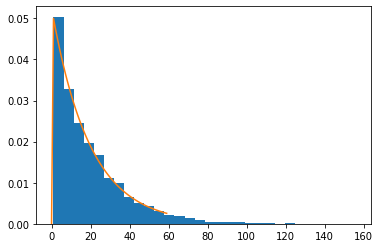

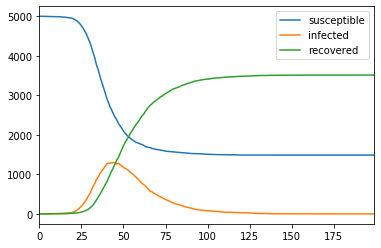

In [126]:
n_contacts_avg = 20.0
p = 1.0 / n_contacts_avg

#G = gen_network(n=population_size, p=0.008, distribution='random')
G = gen_network(n=population_size, p=p)
deg = get_degree_dist(G)

fig, ax = plt.subplots(1,1)
ax.hist(deg, bins=30, density=True)
x = range(60)
ax.plot(x, geom.pmf(x, p))

# Start with an infection in someone with
# at least `n_contacts_avg` contacts
i = 0
node_degree = 0
while node_degree < n_contacts_avg:
    i += 1
    node_degree = deg[i]
    

infected_nodes = set([i])
susceptible_nodes = set(range(len(G)))
_ = [susceptible_nodes.remove(i) for i in infected_nodes]
recovered_nodes = set([])
beta = 0.01
recovery_days = 14.0
gamma = 1.0 / recovery_days

res = []
for day in range(n_days):
    susceptible_nodes, infected_nodes, recovered_nodes = sir_network_stochastic(
        susceptible_nodes, infected_nodes, recovered_nodes, beta, gamma, 0, G)
    res.append({'day': day,
                'susceptible': len(susceptible_nodes),
                'infected': len(infected_nodes),
                'recovered': len(recovered_nodes)})
    
sim_df = pd.DataFrame(data=res, columns = ("day", "susceptible", "infected", "recovered"))

sim_df_net = sim_df
sim_df[["susceptible","infected", "recovered"]].plot()

In [18]:
sim_df_net.head()

,day,susceptible,infected,recovered
0,0,4999,1,0
1,1,4999,1,0
2,2,4999,1,0
3,3,4999,1,0
4,4,4999,1,0


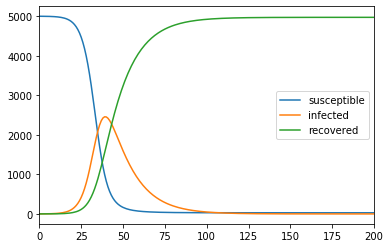

In [19]:
i = 1
s = population_size - i
r = 0
nu = 1.0
beta = 0.35
sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
                columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot()

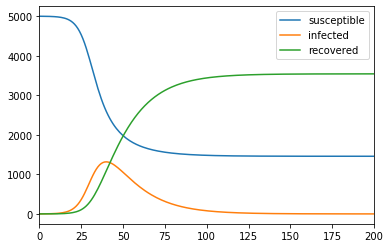

In [20]:
i = 1
s = population_size - i
r = 0
nu = 2.5
beta = 0.35
sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
                columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot()

In [21]:
def loss(params):
    beta, nu = params
    i = 1
    s = population_size - i
    r = 0
    sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
                columns = ("day", "susceptible", "infected", "recovered"))
    
    return ((sim_df_net - sim_df)**2).sum().sum()
loss((0.25, 1.0))

503745411.7794876

In [22]:
sim_df_net 

,day,susceptible,infected,recovered
0,0,4999,1,0
1,1,4999,1,0
2,2,4999,1,0
3,3,4999,1,0
4,4,4999,1,0
...,...,...,...,...
195,195,1462,0,3538
196,196,1462,0,3538
197,197,1462,0,3538
198,198,1462,0,3538


Optimization terminated successfully.
         Current function value: 335073.100528
         Iterations: 57
         Function evaluations: 109


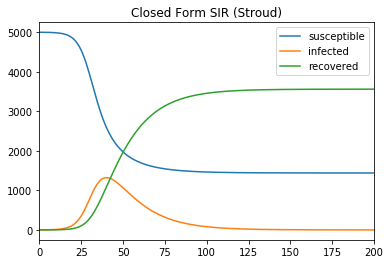

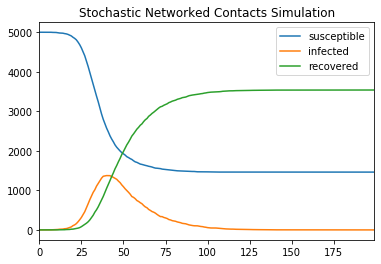

In [23]:
from scipy.optimize import fmin
start_params = 0.25, 1.0
beta, nu = fmin(loss, x0=start_params)
sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
                columns = ("day", "susceptible", "infected", "recovered"))
sim_df[["susceptible","infected", "recovered"]].plot(title='Closed Form SIR (Stroud)')
sim_df_net[["susceptible","infected", "recovered"]].plot(title='Stochastic Networked Contacts Simulation')

#### Next we'll fit the exponent $\nu$ for a wide range of exponential degree-distribution parameterizations

- For each individual-based model with network structure, fit $\beta$ and $\nu$ using the Stroud approximation:

20
Optimization terminated successfully.
         Current function value: 537377.823941
         Iterations: 56
         Function evaluations: 107


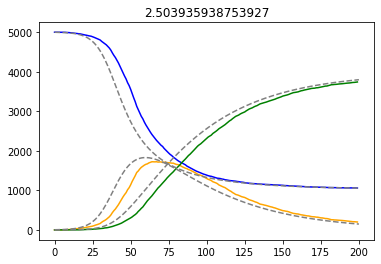

21
Optimization terminated successfully.
         Current function value: 479486.609988
         Iterations: 59
         Function evaluations: 110


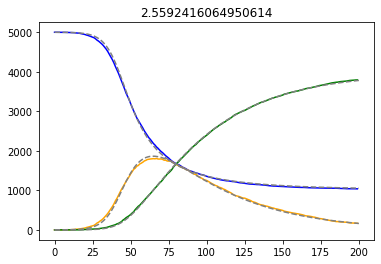

22
Optimization terminated successfully.
         Current function value: 330978.285064
         Iterations: 61
         Function evaluations: 117


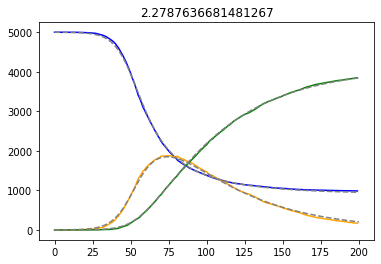

23
Optimization terminated successfully.
         Current function value: 329012.639992
         Iterations: 56
         Function evaluations: 109


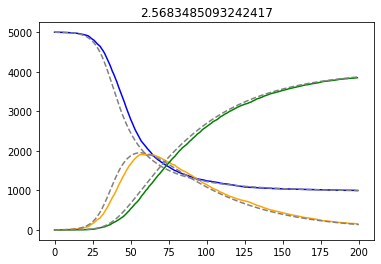

24
Optimization terminated successfully.
         Current function value: 377023.437098
         Iterations: 63
         Function evaluations: 116


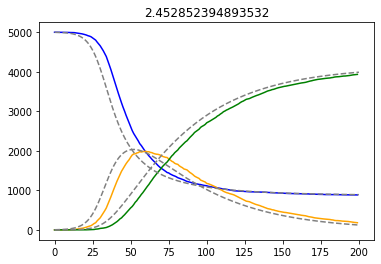

25
Optimization terminated successfully.
         Current function value: 216260.481662
         Iterations: 62
         Function evaluations: 117


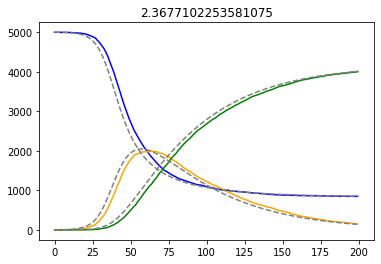

26
Optimization terminated successfully.
         Current function value: 265232.798613
         Iterations: 55
         Function evaluations: 107


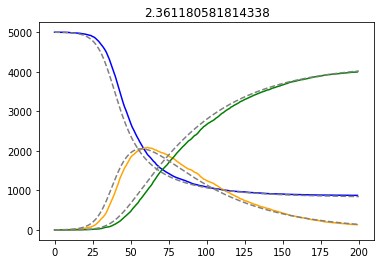

27
Optimization terminated successfully.
         Current function value: 653948.079016
         Iterations: 52
         Function evaluations: 103


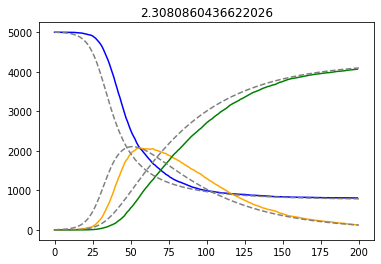

28
Optimization terminated successfully.
         Current function value: 319317.157217
         Iterations: 58
         Function evaluations: 109


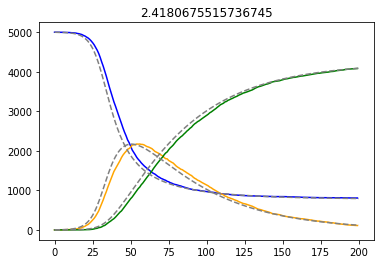

29
Optimization terminated successfully.
         Current function value: 128373.388193
         Iterations: 57
         Function evaluations: 111


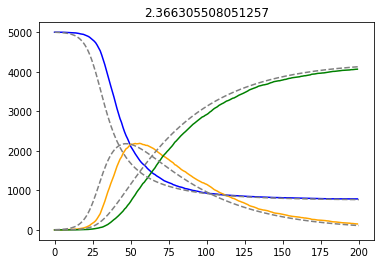

30
Optimization terminated successfully.
         Current function value: 1840597.590444
         Iterations: 58
         Function evaluations: 108


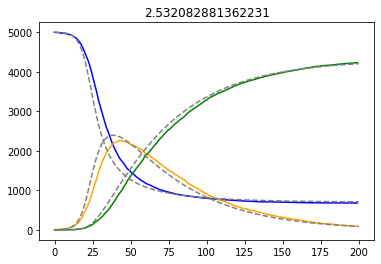

31
Optimization terminated successfully.
         Current function value: 185347.988420
         Iterations: 56
         Function evaluations: 108


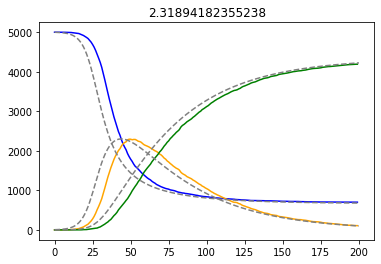

32
Optimization terminated successfully.
         Current function value: 269896.355462
         Iterations: 54
         Function evaluations: 102


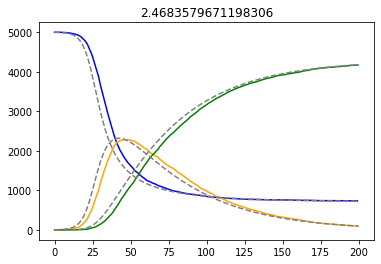

33
Optimization terminated successfully.
         Current function value: 384697.147734
         Iterations: 51
         Function evaluations: 98


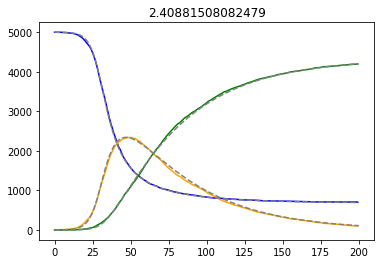

34
Optimization terminated successfully.
         Current function value: 425297.024314
         Iterations: 57
         Function evaluations: 108


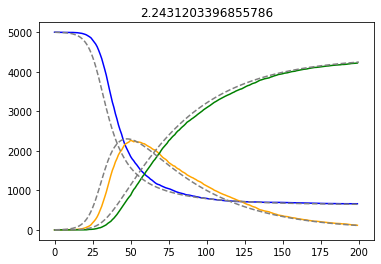

35
Optimization terminated successfully.
         Current function value: 801613.368425
         Iterations: 51
         Function evaluations: 99


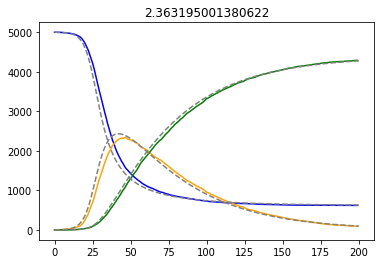

36
Optimization terminated successfully.
         Current function value: 344338.858802
         Iterations: 52
         Function evaluations: 97


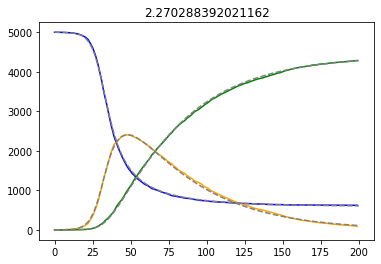

37
Optimization terminated successfully.
         Current function value: 331321.144302
         Iterations: 51
         Function evaluations: 98


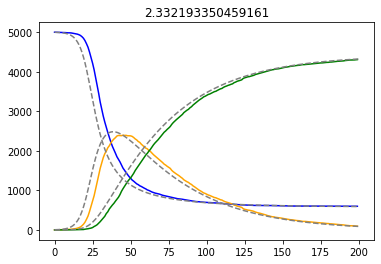

38
Optimization terminated successfully.
         Current function value: 506116.579991
         Iterations: 53
         Function evaluations: 99


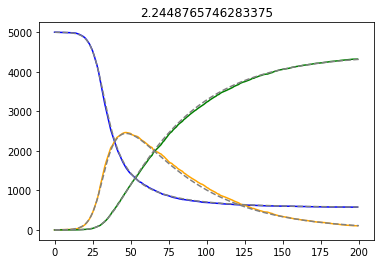

39
Optimization terminated successfully.
         Current function value: 1481148.857064
         Iterations: 53
         Function evaluations: 103


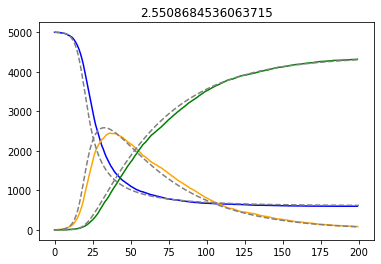

40
Optimization terminated successfully.
         Current function value: 495950.009918
         Iterations: 47
         Function evaluations: 94


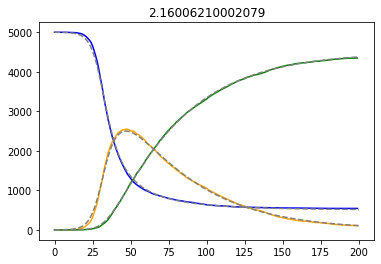

41
Optimization terminated successfully.
         Current function value: 8082644.111384
         Iterations: 66
         Function evaluations: 128


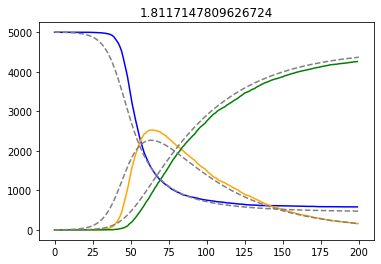

42
Optimization terminated successfully.
         Current function value: 2247072.176014
         Iterations: 53
         Function evaluations: 103


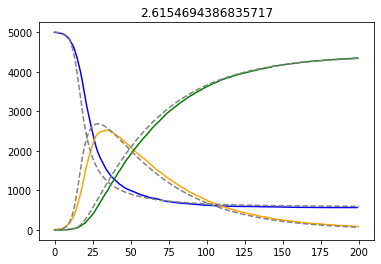

43
Optimization terminated successfully.
         Current function value: 1302671.411787
         Iterations: 53
         Function evaluations: 106


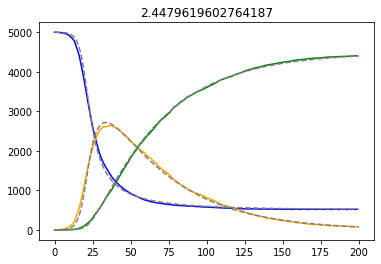

44
Optimization terminated successfully.
         Current function value: 394354.058402
         Iterations: 56
         Function evaluations: 105


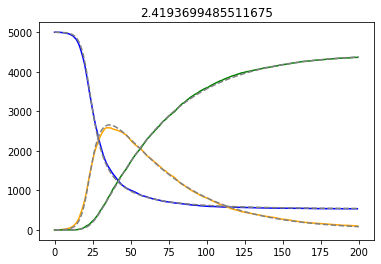

45
Optimization terminated successfully.
         Current function value: 1185692.126088
         Iterations: 53
         Function evaluations: 103


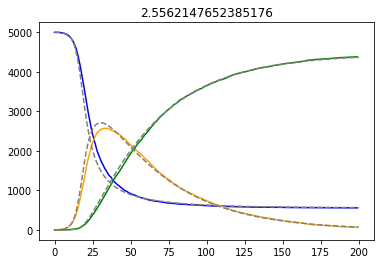

46
Optimization terminated successfully.
         Current function value: 889942.208944
         Iterations: 54
         Function evaluations: 104


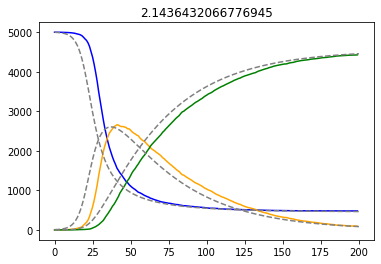

47
Optimization terminated successfully.
         Current function value: 2244332.154774
         Iterations: 55
         Function evaluations: 108


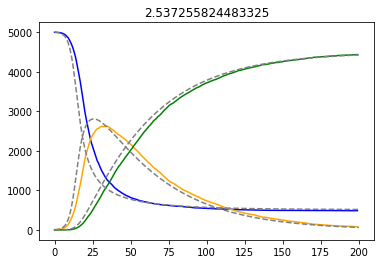

48
Optimization terminated successfully.
         Current function value: 283218.761386
         Iterations: 55
         Function evaluations: 105


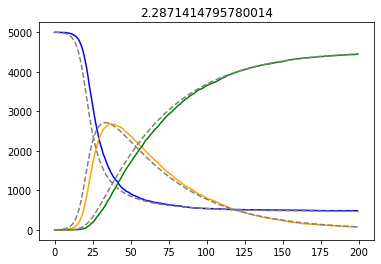

49
Optimization terminated successfully.
         Current function value: 870841.729061
         Iterations: 70
         Function evaluations: 137


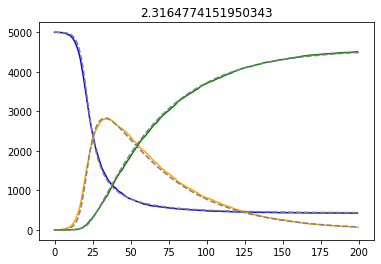

50


/Users/cchivers/anaconda2/envs/hypertensionbot/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/cchivers/anaconda2/envs/hypertensionbot/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  
/Users/cchivers/anaconda2/envs/hypertensionbot/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


Optimization terminated successfully.
         Current function value: 28210282.787060
         Iterations: 111
         Function evaluations: 230


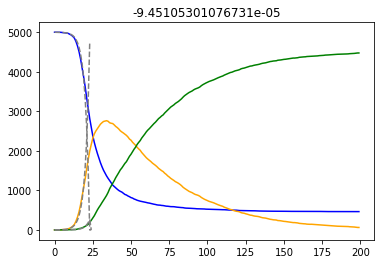

51
Optimization terminated successfully.
         Current function value: 653246.821548
         Iterations: 55
         Function evaluations: 107


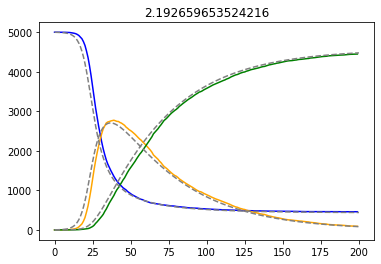

52
Optimization terminated successfully.
         Current function value: 1532763.285218
         Iterations: 53
         Function evaluations: 105


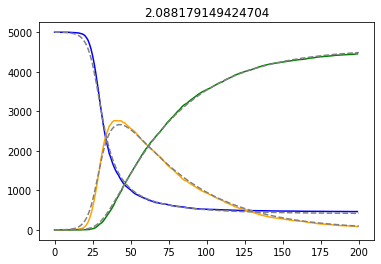

53
Optimization terminated successfully.
         Current function value: 2502468.174431
         Iterations: 51
         Function evaluations: 98


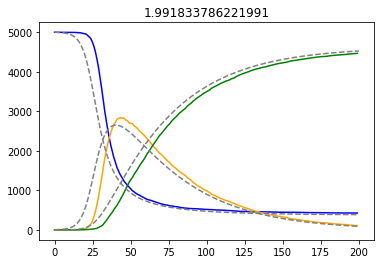

54
Optimization terminated successfully.
         Current function value: 354800.532712
         Iterations: 56
         Function evaluations: 103


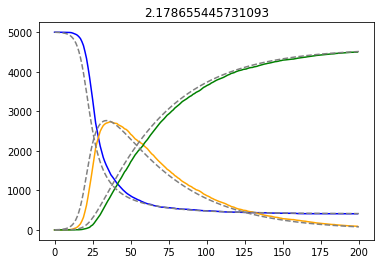

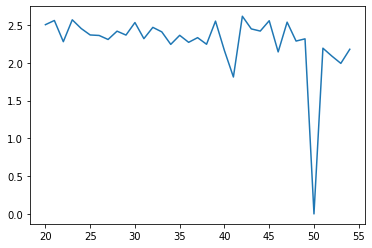

In [129]:
fitted_nu = []
contacts_avgs = range(20,55)
for n_contacts_avg in contacts_avgs:
    print(n_contacts_avg)
    p = 1.0 / n_contacts_avg

    burnout = True
    while burnout:
        G = gen_network(n=population_size, p=p) 
        deg = get_degree_dist(G)

        # Start with an infection in someone with
        # at least 5 contacts
        i = 0
        node_degree = 0
        while node_degree < n_contacts_avg:
            i += 1
            node_degree = deg[i]

        infected_nodes = set([i])
        susceptible_nodes = set(range(len(G)))
        _ = [susceptible_nodes.remove(i) for i in infected_nodes]
        recovered_nodes = set([])
        beta = 0.005
        gamma = 1/40.

        res = []
        for day in range(n_days):
            susceptible_nodes, infected_nodes, recovered_nodes = sir_network_stochastic(
                susceptible_nodes, infected_nodes, recovered_nodes, beta, gamma, 0, G)
            res.append({'day': day,
                        'susceptible': len(susceptible_nodes),
                        'infected': len(infected_nodes),
                        'recovered': len(recovered_nodes)})

        global sim_df_net
        sim_df_net = pd.DataFrame(data=res, columns = ("day", "susceptible", "infected", "recovered"))
        if sim_df_net['infected'].max() > 10:
            burnout = False
    
    start_params = 0.25, 1.0
    beta, nu = fmin(loss, start_params)
    sim_df = pd.DataFrame(data=gen_sir_stroud(s, i, r, beta, nu, gamma, n_days),
                    columns = ("day", "susceptible", "infected", "recovered"))
    
    fig, ax = plt.subplots(1,1)
    ax.plot(sim_df_net['susceptible'], label="susceptible IBM", color='blue')
    ax.plot(sim_df_net['infected'], label="infected IBM", color='orange')
    ax.plot(sim_df_net['recovered'], label="recovered IBM",color='green')
    
    ax.plot(sim_df['susceptible'], '--', label="susceptible Stroud", color='grey')
    ax.plot(sim_df['infected'], '--', label="infected Stroud",color='grey')
    ax.plot(sim_df['recovered'], '--', label="recovered Stroud", color='grey')
    ax.set_title(str(nu))
    plt.show()
    fitted_nu.append(nu)

fitted_nu = np.array(fitted_nu)
fitted_nu[fitted_nu > 100] = np.nan
plt.plot(contacts_avgs, fitted_nu)

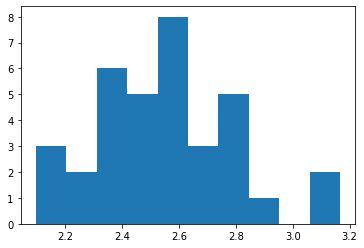

In [25]:
plt.hist(pd.Series(fitted_nu).dropna().values);

# Non-exhaustive list of outstanding questions
- Can we fit these models to data we have so far
    - If so, will they be distinguisible given the early stage?
        - **No**
    - However, we can approximate $\nu$ using IBM simulations
- Effect of distancing will be different (stonger?) in models containing/accounting for contact structure
- These extensions assume particular network structures (degree distributions). Bansal et al find exponentially destirbuted degree-distributions to fit several real-world datasets best..

In [29]:
import networkx as nx

In [145]:
GG = {k:G[k] for k in range(50)}

In [146]:
def gen_nx_graph(GG):
    Gnx = nx.Graph()
    Gnx.add_nodes_from(GG.keys())
    for node,edges in GG.items():
        for edge in edges:
            Gnx.add_edge(node, edge)
    return Gnx

In [147]:
Gnx = gen_nx_graph(GG)
Gnx.number_of_nodes()

1783

In [148]:
options = {
    'node_color': 'black',
    'node_size': 1,
}

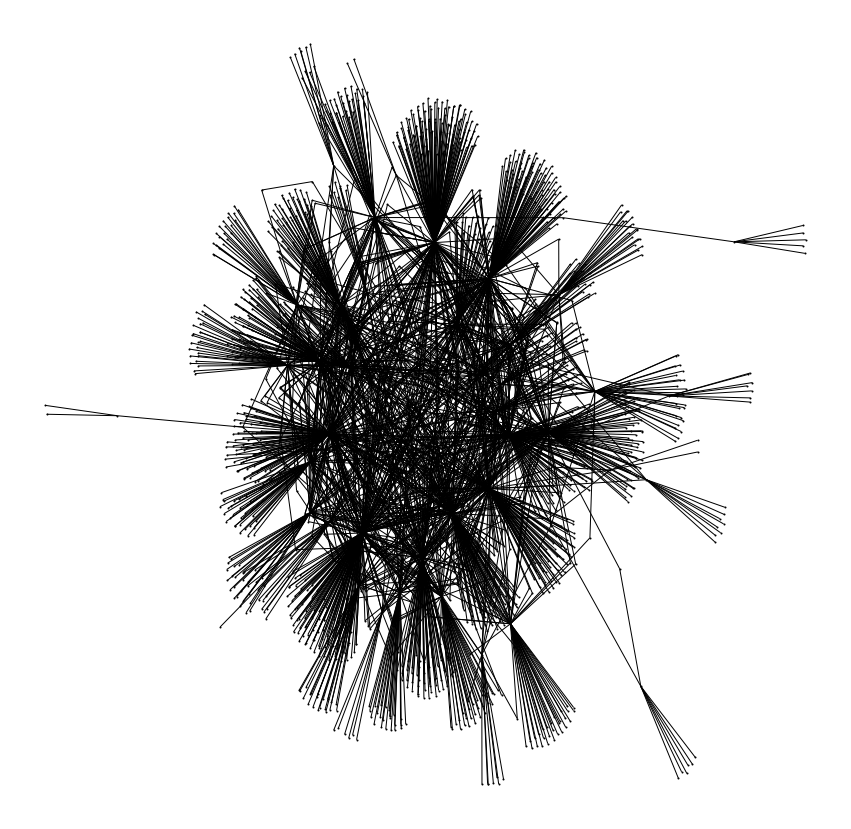

In [149]:
def save_graph(graph,file_name):
    #initialze Figure
    fig, ax = plt.subplots(1,1, figsize=(15, 15))
    ax.axis('off')
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos, ax=ax, **options)
    nx.draw_networkx_edges(graph,pos, ax=ax, **options)

    #plt.savefig(file_name,bbox_inches="tight")
    #pylab.close()

#Assuming that the graph g has nodes and edges entered
save_graph(Gnx,"my_graph.pdf")
plt.show()